<font color=red face="Jazz LET" size="7">MAMBO</font>

<font color=blue face="Times" size="5">*Mocks with Abundance Matching in Bologna*</font>

by  
Xavier López  
Micol Bolzonella  
Lucia Pozzetti  
Giacomo Girelli  
Laura Bisigello

# Setup parameters

In [72]:
#Import python libraries

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker


import pandas as pd
import scipy as sp
from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column

import time
import textwrap

**Cosmology:**
* EGG assumes $H_0 = 70\,\mathrm{km\, s^{-1}\, Mpc^{-1}}$, $\Omega_m=0.3$, $\Omega_\Lambda =0.7$
* Millennium cosmological parameters (in table MRscPlanck1) are $\Omega_m=0.315$, $\Omega_\Lambda =0.685$, $H_0 = 67.3\,\mathrm{km\, s^{-1}\, Mpc^{-1}}$
(see http://gavo.mpa-garching.mpg.de/MyMillennium/Help?page=simulation). We will use EGG cosmology, while halo masses from Millennium have an explicit dependence on the Hubble parameter.

**IMF:** set the conversion between stellar masses with Chabrier (default in the SHMR) and Salpeter (used in EGG) IMF.

**Paths:** The paths of all the folders needed in this notebook.

Notice also that the size of the Millennium simulation box is $L = 480.279$Mpc$/h$ and that the Henriques lightcones are circular with a diameter of 2 deg.



In [63]:
start_time = time.time()

# cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
h=cosmo.H(0).value/100
print('The value of the Hubble parameter h='+str(h)+' will be used')

#area of the lightcone
area_mambo = np.pi

# mass and SFR conversion from Chabrier to Salpeter
imf = 0.23

# definitions for flux to mag conversion
refmag = [8.9,16.4,23.9,-48.6]
flux = ['Jy','mJy','muJy','cgs']
flux_dict = dict([(n,rm) for (n,rm) in zip(flux, refmag)])
funit='muJy' # predefine fluxes unit as in EGG (change where needed)

#path definitions
# HOMEDIR = '/content/drive/Shared drives/EGG-Millennium/MAMBO Workflow/' # Home folder of the workflow
DATADIR = 'DATA/' # Folder with data of SHMR etc.
DMDIR   = 'DM/'   # Dark Matter
INEGGDIR  = 'EGG_IN/' # Files ready for EGG input
OUTEGGDIR = 'EGG_OUT/' # EGG outputs
# MOCKDIR = HOMEDIR+'MOCKS/' # final mocks
# FIGDIR = HOMEDIR+'FIGURES/' # Figures
# COSMOSDIR = '/content/drive/Shared drives/EGG-Millennium/EXTDATA/COSMOS/'

# sys.path.append(HOMEDIR)
# import fancyplot


The value of the Hubble parameter h=0.7 will be used


Read lightcone file

In [37]:
lc=23 #Only 1 or 23 allowed at the moment
zmax = 10. #Maximum redshift of the lightcone

file = 'Millennium_Planck_H15_BC03_lightcone'+str(lc).zfill(3)+'.pkl'
df = pd.read_pickle(DMDIR+file)
# be sure that the dataframe is sorted in z_app
df.sort_values(by=['z_app'], axis=0, ignore_index=True,inplace=True)

# Assign stellar mass through the SHMR

The needed input for this part is
* ID: <font face=courier color=blue>GalaxyID</font>
* ra: <font face=courier color=blue>ra</font>
* dec: <font face=courier color=blue>dec</font>
* redshift: <font face=courier color=blue>z_app</font>
* infall halo mass (in units of h=1): <font face=courier color=blue>mvir</font>, defined as <br> *10^10 Msun/h	Virial mass (as defined by m_crit200) of the FOF group this galaxy was in when last it was a type 0 galaxy. I.e. current mass for type 0 galaxies, "infall virial mass" for type 1,2 galaxies.* <br>
Notice that the SHMR is derived assuming h=0.7, therefore the used value of <font face=courier color=blue>mvir</font> will be actually <font face=courier color=blue>mvir/0.7 * 10^10</font>.

In [38]:
#@title Functions for SHMR model
def getlM1(z):
    lM1 = 12.0989+(z*0.1457)
    return lM1

def getlM2(z):
    y=-0.4119*(z-3.5)+12.609
    return y

def getmM0(z):
    mM0 = 0.02347*pow(1+z,-0.1078)
    return mM0

def getgamma(z):
    gamma = 0.7000*pow(1+z,-0.20725)
    return gamma

def getbeta(z):
    beta = 1.0156
    return beta

def getMstar(Mh,z):
    Mstar = Mh*(2*getmM0(z)/(pow(Mh/pow(10,getlM1(z)),-getbeta(z)) + pow(Mh/pow(10,getlM1(z)),getgamma(z))))
    return Mstar

def getMstar_2(Mh,z):
    Mstar = Mh*(2*getmM0(z)/(pow(Mh/pow(10,getlM2(z)),-getbeta(z)) + pow(Mh/pow(10,getlM2(z)),getgamma(z))))
    return Mstar

In [39]:
#@title derive stellar mass (notice that the SHMR changes at z=3.5)

zthresh = 3.5

i = (df['z_app']<=zthresh)
redshift_A = df['z_app'][i]
Minf_A = np.log10(df['mvir'][i])+10.

i = (df['z_app']>zthresh)
redshift_B = df['z_app'][i]
Minf_B = np.log10(df['mvir'][i])+10.

Ms_A = getMstar(10**(Minf_A)/h,redshift_A)
Ms_B = getMstar_2(10**(Minf_B)/h,redshift_B)
#Ms = np.concatenate([Ms_A,Ms_B])
## Notice that this works because there is a sort in redshift!!!
# Ms = Ms_A.append(Ms_B, ignore_index=True)
Ms = pd.concat([Ms_A,Ms_B], ignore_index=True) #Xavi: changed to concat because .append is not suported anymore

In [40]:
#@title apply scatter (0.2 dex - not modifiable)
#random seed for scatter: fix it to have always the same sequence in case the code needs to be rerun
np.random.seed(2021)
# scatter in dex: this is the scatter adopted to derive the SHMR, it cannot be changed easily
scatter = 0.2
sigma_m = np.log10(np.random.lognormal(0,scatter,len(df)))
Ms_m = 10**(np.log10(Ms)+sigma_m)

In [41]:
df['m_chab'] = pd.Series(np.log10(Ms_m), dtype=np.float32)
df['m_chab_noscatter'] = pd.Series(np.log10(Ms), dtype=np.float32)

In [42]:
# #@title test plot of stellar masses with/without scatter
# # zlow,zhigh = w.result
# zlow,zhigh = 0,10


# plt.figure(figsize = [6,5],dpi = 150)
# plt.hist(df['m_chab'].iloc[np.where((df['z_app']>=zlow) & (df['z_app']<zhigh))],
#          bins=50,lw=2,color='forestgreen',histtype='stepfilled',alpha=0.6,
#          label='Stellar mass with scatter ($\sigma=0.2$ dex)')
# plt.hist(df['m_chab_noscatter'].iloc[np.where((df['z_app']>=zlow) & (df['z_app']<zhigh))],
#          bins=50,lw=2,color='firebrick',histtype='step',label='Stellar mass no scatter')

# plt.yscale('log')
# plt.xlim([6,12.3])
# plt.xlabel('$\log(M_*/M_\odot)$',fontsize=13)
# plt.ylabel('number',fontsize=13)
# plt.legend(loc='lower center')
# plt.title((r'$z=$[%.1f'%(zlow)+', %.1f'%(zhigh)+']'))
# plt.show()

# Assign galaxy type

In [43]:
# Define functions
# The function "griddata" returns the interpolation at the points (x,y) = (df['m_chab'],df['z_app'])

def interpol2 (ff):
  (M,frac,z) = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[0,1,2])
  inter = griddata((M,z),frac,(df['m_chab'],df['z_app']), method='linear')
  return inter

## Fraction of SF/P

In [44]:
#read the fractions derived from Ilbert stellar mass functions divided per type and compute interpolation

df['SFP']     = np.zeros(len(df)) #Fraction of SFGs at a given M* and z
df['SFP']     = pd.Series(interpol2('SFfrac_fit_Ilbert_allz_v3.txt'), dtype=np.float32)
# df['SFP']     = np.zeros(len(df)) +1 #for tests

In [45]:
#@title Assign flag of SF/pas

#Random number between 0 and 1 for each object
np.random.seed(2021)
ran_floats = np.random.random(len(df))
df['rand'] = pd.Series(ran_floats, dtype=np.float32)

# define the object class list
passive = np.zeros(len(df))
df['passive'] = pd.Series(passive, dtype=np.int32)

# assign 1(Q) to objects with probability larger than the threshold from interpolation
df['passive'] = np.where((df['rand']>df['SFP']),1,df['passive'])

numpas = df[df['passive'] == 1]['passive'].count()
numsf = df[df['passive'] == 0]['passive'].count()
print("Number of passive galaxies: ", numpas, '(%2.2f' %(numpas/(numpas + numsf)*100),"%)")
print("Number of SF galaxies:     ",   numsf, '(%2.2f'  %(numsf/(numpas + numsf)*100),"%)")

Number of passive galaxies:  133344 (1.68 %)
Number of SF galaxies:      7823902 (98.32 %)


## Fraction of AGN


In [46]:
#@title Fraction of AGN
   #Assign a probability for a galaxy to host an AGN from the duty cycle of Bongiorno+16
   #We assume that AGN occur with the same p(M*,z) in SFGs and Qs
   #We interpret that the AGN in Bongiorno+16 are both type 1 and 2, and we separate later using Merloni+14
    

df['sfAGNfrac'] = pd.Series(interpol2('AGNfrac_Bong_flat.txt'), dtype=np.float32) 

#Bongiorno16 does not include CT AGN, but only 20 < log(NH) < 24. It is possible to include CT assuming that they
# represent a constant fraction at all z and M*, e.g. 35% (Buchner et al. 2015)
# CTfrac = 0.35
# df['sfAGNfrac'] = df['sfAGNfrac']/(1-CTfrac)

df['pasAGNfrac'] = df['sfAGNfrac'] 
# df['pasAGNfrac'] = 0 #for tests
# df['sfAGNfrac'] = 0.1 #for tests


In [47]:
#@title Assign flag of AGN 0/3

#Random number between 0 and 1 for each object
np.random.seed(2022)
ran_floats = np.random.random(len(df))
df['rand'] = pd.Series(ran_floats, dtype=np.float32)

agn =np.zeros(len(df))
df['agn'] = pd.Series(agn, dtype=np.int32)
# assign 0 to non-AGN,3 to AGN
df['agn'] = np.where(( (df['passive']==0) & (df['rand']<df['sfAGNfrac']) ),3,df['agn'] )
df['agn'] = np.where(( (df['passive']==1) & (df['rand']<df['pasAGNfrac']) ),3,df['agn'] )

# numsf1 = df[(df['passive'] == 0) & (df['agn'] == 1)]['agn'].count()
# numsf2 = df[(df['passive'] == 0) & (df['agn'] == 2)]['agn'].count()
# numsf3 = df[(df['passive'] == 0) & (df['agn'] == 3)]['agn'].count()
# numsf0 = df[(df['passive'] == 0) & (df['agn'] == 0)]['agn'].count()
# nump1 = df[(df['passive'] == 1) & (df['agn'] == 1)]['agn'].count()
# nump2 = df[(df['passive'] == 1) & (df['agn'] == 2)]['agn'].count()
# nump3 = df[(df['passive'] == 1) & (df['agn'] == 3)]['agn'].count()
# nump0 = df[(df['passive'] == 1) & (df['agn'] == 0)]['agn'].count()
# print("AGN1 in SF galaxies:      ", numsf1, '(%.2f' %(numsf1/numsf*100),"%)",    ' (%.2f' %(numsf1/len(df)*100),"%) of total")
# print("AGN2 in SF galaxies:      ", numsf2, '(%.2f' %(numsf2/numsf*100),"%)",     ' (%.2f' %(numsf2/len(df)*100),"%) of total")
# print("AGN in SF galaxies:      ", numsf3, '(%.2f' %(numsf3/numsf*100),"%)",     ' (%.2f' %(numsf3/len(df)*100),"%) of total")
# print("Non-AGN SF galaxies:    ", numsf0, '(%.2f' %(numsf0/numsf*100),"%)",      ' (%.2f' %(numsf0/len(df)*100),"%) of total \n")
# print("AGN1 in passive galaxies:     ", nump1,  '(%.0f' %(nump1/numpas*100),"%)",' (%.2f' %(nump1/len(df)*100),"%) of total")
# print("AGN2 in passive galaxies:  ", nump2, '(%.2f' %(nump2/numpas*100),"%)",    ' (%.2f' %(nump2/len(df)*100),"%) of total")
# print("AGN in passive galaxies:  ", nump3, '(%.2f' %(nump3/numpas*100),"%)",    ' (%.2f' %(nump3/len(df)*100),"%) of total")
# print("Non-AGN passive galaxies:",   nump0, '(%.2f' %(nump0/numpas*100),"%)",    ' (%.2f' %(nump0/len(df)*100),"%) of total \n")


In [48]:
#@title Assign BH mass

#The relation used by Aird,Marconi & Hunt 2003
#https://ui.adsabs.harvard.edu/abs/2003ApJ...589L..21M/abstract

df['Mbh'] = 0.002*df['m_chab']

#Many other more modern relations exist (to be explored)


# X-ray luminosity

In [49]:
#Redshift threshold to use the accretion rate distributions from Bongiorno+16 (for z < zbreak) or Aird+18
zbreak_bon_aird = 2.0

## Assign Lx

In [50]:
#@title P(l) from Bongiorno+16, with stellar mass dependence

def lamf_double_power_law(lam,lams,phis,gam1,gam2):
  phi=phis/(((lam/lams)**-gam1 + (lam/lams)**-gam2))
  return phi

df['Lx_bon'] = np.zeros(len(df))
df['loglambda_bon'] = np.zeros(len(df))
np.random.seed(2024)
ran_floats = np.random.random(len(df))
agnmask = (df['agn'] != 0)

for ii in [0,1,2]:
  zlow  = [0.0,0.8,1.5]
  zhigh = [0.8,1.5,10]
  zmask = (df['z_app']>=zlow[ii]) & (df['z_app']<zhigh[ii])

  mlow = 9.75
  mhigh = 12.25
  mbin = 0.5
  for mm in np.arange(mlow,mhigh,mbin):
    if mm == mlow:
      mmask = (df['m_chab'] >= np.min(df['m_chab'])) & (df['m_chab'] < mm + mbin/2)
    else:
      mmask = (df['m_chab'] >= mm - mbin/2) & (df['m_chab'] < mm + mbin/2)
    mzmask = agnmask & zmask & mmask
    agn_tot = len(df[mzmask])
    vol1 = cosmo.comoving_volume(zlow[ii]).value/(360*360/np.pi)
    vol2 = cosmo.comoving_volume(zhigh[ii]).value/(360*360/np.pi)
    agn_per_mpc3 = agn_tot/(area_mambo*(vol2-vol1)) 
    n_bins = 100
    lammin = 32
    lammax = 36
    lam = np.linspace(lammin,lammax,n_bins)
    lams = 33.8 -0.48*(mm - 11) #Bongiorno+2016 Table 1
    phis = [10**(-6.04),10**(-5.22),10**(-4.85)] #Bongiorno+2016 Table 3
    gam1 = [-1.35,-1.02,-0.54]
    gam2 = [-3.64,-3.61,-3.58]
    phi = lamf_double_power_law(10**lam,10**lams,phis[ii],gam1[ii],gam2[ii])
    prob_phi = phi/agn_per_mpc3
    cdf = np.cumsum(prob_phi)/max(np.cumsum(prob_phi))
    ff = sp.interpolate.interp1d(cdf,lam,bounds_error=False,fill_value="extrapolate")
    df['loglambda_bon'][mzmask] = ff(ran_floats[mzmask])
    df['Lx_bon'][mzmask] =  df['loglambda_bon'][mzmask]  + df['m_chab'][mzmask]

#     plt.figure(figsize = [5,5], dpi = 100)
#     plt.plot(lam, cdf,'.')
#     plt.hist(df['loglambda_bon'][zmask & mmask],bins = 100,cumulative = True,density = True)


# plt.figure(figsize = [7,5], dpi = 100)
# plt.plot(df['z_app'][agnmask],df['Lx_bon'][agnmask],',')
# plt.plot(df['m_chab'][agnmask],df['Lx_bon'][agnmask],',')
# plt.show()

In [51]:
#@title P(l) SF Aird+18
#Use only for z > zbreak_bon_aird (2.0)
# The values of loglam are equispaced (to be considered when constructinc the cdf)

pd.options.mode.chained_assignment = None  # default='warn'. Set = None to avoid lots of warnings (https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

ff = 'pledd_sf.dat'
z_lo, z_hi, mass_lo, mass_hi, loglam, p_lam, p_lam_low, p_lam_up, flag = np.genfromtxt(DATADIR+ff,unpack=True)

 #Select only values with log(lambda) < 1 and flag = 1
 #(flag = 0 indicates potential for significant contamination by star formation thus unreliable.)
good_values = (flag == 1) & (loglam < 1) & (loglam > -2)
z_lo = z_lo[good_values]
z_hi = z_hi[good_values]
mass_lo = mass_lo[good_values]
mass_hi = mass_hi[good_values]
loglam = loglam[good_values]
p_lam = p_lam[good_values]
p_lam_low = p_lam_low[good_values]
p_lam_up = p_lam_up[good_values]


df['loglambda_aird'] = np.zeros(len(df))
df['Lx_aird'] = np.zeros(len(df))

 #random numbers between 0 and 1
np.random.seed(2025)
ran_floats = np.random.random(len(df))

for mlo in np.unique(mass_lo):
  for zlo in np.unique(z_lo[mass_lo == mlo]):
      #Select mass and redshift range
    mhi = mass_hi[mass_lo == mlo][0]
    zhi = z_hi[(mass_lo == mlo) & (z_lo == zlo)][0]
    Mzmask = (z_lo == zlo) & (z_hi == zhi) & (mass_lo == mlo) & (mass_hi == mhi)
    Mzmask_df = (df['passive']==0) & (df['agn'] != 0)
    # print(zlo, mlo)
    if mlo != 8.5:
      Mzmask_df = Mzmask_df & (df['m_chab'] >= mlo)
    if mhi != 11.5:
      Mzmask_df = Mzmask_df & (df['m_chab']<mhi)
    if zlo != 0.1:
      Mzmask_df = Mzmask_df & (df['z_app']>=zlo)
    if zhi != z_hi[(mass_lo == mlo)][0]:
      Mzmask_df = Mzmask_df & (df['z_app'] < zhi)
    # df['loglambda_aird'][Mzmask_df] = np.random.choice(loglam[Mzmask],size =len(df), p = p_lam[Mzmask]/p_lam[Mzmask].sum())   #Try a different way, without the cdf, same result
      #Calculate cumulative distribution function and assign log(lambda)
    cdf = np.cumsum(p_lam[Mzmask])/max(np.cumsum(p_lam[Mzmask]))
    cdf_up = np.cumsum(p_lam_up[Mzmask])/max(np.cumsum(p_lam_up[Mzmask]))
    cdf_low = np.cumsum(p_lam_low[Mzmask])/max(np.cumsum(p_lam_low[Mzmask]))
    ff = sp.interpolate.interp1d(cdf,loglam[Mzmask],bounds_error=False,fill_value="extrapolate")
    df['loglambda_aird'][Mzmask_df] = ff(ran_floats[Mzmask_df])
    kbol = 25
    # kbol = a*(1+((np.log10(df['Lx']/Lsun))/b)**c)
    df['Lx_aird'][Mzmask_df] =  df['loglambda_aird'][Mzmask_df] + df['m_chab'][Mzmask_df] + np.log10(1.3e38*0.002/kbol)

      # plt.figure(figsize=[9,6], dpi = 100)
      # plt.plot(loglam[Mzmask], cdf,'.', label = 'cdf, N_points =' + str(np.sum(Mzmask)))
      # # # plt.plot(loglam[Mzmask], cdf_up,'.', label = 'up')
      # # # plt.plot(loglam[Mzmask], cdf_low,'.', label = 'low')
      # plt.hist(df['loglambda_aird'][Mzmask_df],bins = 100,cumulative = True,density = True,label = 'Assigned loglam, N_points =' + str(np.sum(Mzmask_df)))
      # plt.text(0.3,0.8,(str(zlo) + ' < z < '+ str(zhi)), fontsize = 13)
      # plt.text(0.3,0.7,(str(mlo) + ' < M* < '+ str(mhi)), fontsize = 13)
      # plt.legend()



In [52]:
#@title P(lambda) passive
ff = 'pledd_qu.dat'
z_lo, z_hi, mass_lo, mass_hi, loglam, p_lam, p_lam_low, p_lam_up, flag = np.genfromtxt(DATADIR+ff,unpack=True)

 #Select only values with log(lambda) < 1 and flag = 1
 #(flag = 0 indicates potential for significant contamination by star formation thus unreliable.)
good_values = (flag == 1) & (loglam < 1) & (loglam > -2)
z_lo = z_lo[good_values]
z_hi = z_hi[good_values]
mass_lo = mass_lo[good_values]
mass_hi = mass_hi[good_values]
loglam = loglam[good_values]
p_lam = p_lam[good_values]
p_lam_low = p_lam_low[good_values]
p_lam_up = p_lam_up[good_values]


# df['loglambda_aird'] = np.zeros(len(df))
 #random numbers between 0 and 1
np.random.seed(2026)
ran_floats = np.random.random(len(df))

for mlo in np.unique(mass_lo):
  for zlo in np.unique(z_lo[mass_lo == mlo]):
    #Select mass and redshift range
    mhi = mass_hi[mass_lo == mlo][0]
    zhi = z_hi[(mass_lo == mlo) & (z_lo == zlo)][0]
    Mzmask = (z_lo == zlo) & (z_hi == zhi) & (mass_lo == mlo) & (mass_hi == mhi)
    Mzmask_df = (df['passive']==1) & (df['agn'] != 0)
    if mlo != 8.5:
      Mzmask_df = Mzmask_df & (df['m_chab'] >= mlo)
    if mhi != 11.5:
      Mzmask_df = Mzmask_df & (df['m_chab']<mhi)
    if zlo != 0.1:
      Mzmask_df = Mzmask_df & (df['z_app']>=zlo)
    if zhi != z_hi[(mass_lo == mlo)][0]:
      Mzmask_df = Mzmask_df & (df['z_app'] < zhi)
    # df['loglambda_aird'][Mzmask_df] = np.random.choice(loglam[Mzmask],size =len(df), p = p_lam[Mzmask]/p_lam[Mzmask].sum())   #Try a different way, without the cdf, same result
      #Calculate cumulative distribution function and assign log(lambda)
    cdf = np.cumsum(p_lam[Mzmask])/max(np.cumsum(p_lam[Mzmask]))
    ff = sp.interpolate.interp1d(cdf,loglam[Mzmask],bounds_error=False,fill_value="extrapolate")
    df['loglambda_aird'][Mzmask_df] = ff(ran_floats[Mzmask_df])
    df['Lx_aird'][Mzmask_df] =  df['loglambda_aird'][Mzmask_df] + df['m_chab'][Mzmask_df] + np.log10(1.3e38*0.002/kbol)

    # plt.figure(figsize=[9,6], dpi = 100)
    # plt.plot(loglam[Mzmask], cdf,'.', label = 'cdf, N_points =' + str(np.sum(Mzmask)))
    # plt.hist(df['loglambda_aird'][Mzmask_df],bins = 100,cumulative = True,density = True,label = 'Assigned loglam, N_points =' + str(np.sum(Mzmask_df)))
    # plt.legend()

#Calculate Lx from lambda, and Lacc from Lx

# df['Lacc2']= np.zeros(len(df)) -99
# df['Lacc2'][agnmask] = np.log10((kbol -1)*df['Lx3'][agnmask])


#  #Check plot
# plt.figure(figsize=[9,6], dpi = 100)
# # plt.plot(loglam[Mzmask], cdf)
# # plt.plot(loglam[mask], p_lam[mask])
# # plt.fill_between(loglam[mask],p_lam_low[mask], p_lam_up[mask], alpha = 0.5)
# # plt.yscale('log')
# plt.tick_params(axis='both',which='major',direction='in',length=5,labelsize=15)
# plt.tick_params(axis='both',which='minor',direction='in',length=3)


# plt.plot(df['z_app'][(df['passive'] == 0) & (df['agn'] != 0)],df['loglambda_aird'][(df['passive'] == 0) & (df['agn'] != 0)],'b.',ms = 0.5, label = 'SF')
# plt.plot(df['z_app'][(df['passive'] == 1) & (df['agn'] != 0)],df['loglambda_aird'][(df['passive'] == 1) & (df['agn'] != 0)],'r.',ms = 0.5, label = 'passive' )
# plt.xlabel('redshift',fontsize = 15)
# plt.ylabel('log(lambda)',fontsize = 15)
# plt.legend(markerscale = 6)

In [70]:
#@title Merge both distributions
zbreak_bon_aird = 2.0
df['Lx'] = np.zeros(len(df)) -99
df['Lx'] = np.where(df['z_app'] >= zbreak_bon_aird, df['Lx_aird'], df['Lx_bon'])

df['Lacc']= np.zeros(len(df))
df['Lacc'] = df['Lx'] + np.log10((kbol -1))

# plt.plot(df['z_app'][agnmask],df['Lx'][agnmask],'.', ms = 1)
# plt.plot(df['m_chab'][agnmask],df['Lx'][agnmask],'.', ms = 1)

## Separate AGN in Type1/2 

In [54]:
#@title Probability of type2 AGN
#Using eq 1 in Merloni et al 2014, Figure 6
agnmask = (df['agn'] != 0)

A = 0.56
L0 = 43.89
sigx = 0.46

df['Obsc_frac']= np.zeros(len(df))
df['Obsc_frac'][agnmask] = A + np.arctan((L0-df['Lx'][agnmask])/sigx)/np.pi
# # df['Obsc_frac'][(df['Lx'] < 42.5)] = A + np.arctan((L0-42.5)/sigx)/np.pi
# plt.plot(df['Lx'][agnmask], df['Obsc_frac'][agnmask], '.', ms = 1 )
# plt.grid()
# # plt.ylim([0,1])

In [55]:
#@title Assign flag of AGN 1/2
# define the object class list

# Extract a random number between 0 and 1 for each object
np.random.seed(2023)
ran_floats = np.random.random(len(df))
df['rand'] = pd.Series(ran_floats, dtype=np.float32)

# assign 1(2) to type 1(2) AGN
df['agn_m14'] = np.zeros(len(df))
df['agn_m14'][df['agn'] != 0] = np.where((df['agn']!=0) & (df['rand']>df['Obsc_frac']), 1, 2)



# nump1 = df[(df['passive'] == 1) & (df['agn'] == 1)]['agn'].count()
# nump2 = df[(df['passive'] == 1) & (df['agn'] == 2)]['agn'].count()
# nump3 = df[(df['passive'] == 1) & (df['agn'] == 3)]['agn'].count()
# nump0 = df[(df['passive'] == 1) & (df['agn'] == 0)]['agn'].count()
# numsf1 = df[(df['passive'] == 0) & (df['agn'] == 1)]['agn'].count()
# numsf2 = df[(df['passive'] == 0) & (df['agn'] == 2)]['agn'].count()
# numsf3 = df[(df['passive'] == 0) & (df['agn'] == 3)]['agn'].count()
# numsf0 = df[(df['passive'] == 0) & (df['agn'] == 0)]['agn'].count()
# print("AGN1 in passive galaxies:     ", nump1,  '(%.0f' %(nump1/numpas*100),"%)",' (%.2f' %(nump1/len(df)*100),"%) of total")
# print("AGN2 in passive galaxies:  ", nump2, '(%.0f' %(nump2/numpas*100),"%)",    ' (%.2f' %(nump2/len(df)*100),"%) of total")
# print("AGN in passive galaxies:  ", nump3, '(%.0f' %(nump3/numpas*100),"%)",    ' (%.2f' %(nump3/len(df)*100),"%) of total")
# print("Non-AGN passive galaxies:",   nump0, '(%.0f' %(nump0/numpas*100),"%)",    ' (%.2f' %(nump0/len(df)*100),"%) of total \n")
# print("AGN1 in SF galaxies:      ", numsf1, '(%.2f' %(numsf1/numsf*100),"%)",    ' (%.2f' %(numsf1/len(df)*100),"%) of total")
# print("AGN2 in SF galaxies:      ", numsf2, '(%.2f' %(numsf2/numsf*100),"%)",     ' (%.2f' %(numsf2/len(df)*100),"%) of total")
# print("AGN in SF galaxies:      ", numsf3, '(%.2f' %(numsf3/numsf*100),"%)",     ' (%.2f' %(numsf3/len(df)*100),"%) of total")
# print("Non-AGN SF galaxies:    ", numsf0, '(%.2f' %(numsf0/numsf*100),"%)",      ' (%.2f' %(numsf0/len(df)*100),"%) of total")


## X-ray obscuration

In [56]:
#@title Assign NH to AGN (pythonized version)
# Assign a value of NH as a function of Lx and z following Ueda+14,
# 20 < NH < 24 (No Compton thick AGN)

np.random.seed(2030)

agn_mask = (df['agn'] != 0)

def abs_function(PsiMax):
  Nagn = agn_mask.sum()
  # PsiMax = 0.84
  nh = np.linspace(20.01,23.99,500)
  nh_func = np.empty(shape=(Nagn,len(nh)))
  cdf     = np.empty(shape=(Nagn,len(nh)))

  a1 = 0.48
  eps=1.7
  psimax = np.zeros(Nagn) + PsiMax
  psimin = np.zeros(Nagn) + 0.2
  beta = 0.24
  psilim = (1+eps)/(3+eps) # = 0.57

  psi4375z = np.empty(shape=Nagn)
  psi4375z[(df['z_app'][agn_mask] < 2)] = 0.43*(1+df['z_app'][agn_mask & (df['z_app'] < 2)])**a1
  psi4375z[(df['z_app'][agn_mask] > 2)] = 0.43*(1+2)**a1 # = 0.728

  psiLxz = np.minimum(psimax, np.maximum((psi4375z-beta*(df['Lx'][agn_mask]-43.75)), psimin))
  #len(psiLxz) == Nagn --> True

  nh1 = (nh >= 20) & (nh < 21)
  nh2 = (nh >= 21) & (nh < 22)
  nh3 = (nh >= 22) & (nh < 23)
  nh4 = (nh >= 23) & (nh < 24)

  psimask1 = psiLxz<psilim
  temp = nh_func[:, nh1]
  temp[psimask1] = np.tile((1-((2+eps)/(1+eps))*psiLxz[psimask1]), (nh1.sum(),1)).T
  nh_func[:, nh1] = temp
  # del temp
  temp = nh_func[:, nh2]
  temp[psimask1] = np.tile((1/(1+eps))*psiLxz[psimask1], (nh2.sum(),1)).T
  nh_func[:, nh2] = temp
  # del temp
  temp = nh_func[:, nh3]
  temp[psimask1] = np.tile((1/(1+eps))*psiLxz[psimask1], (nh3.sum(),1)).T
  nh_func[:, nh3] = temp
  # del temp
  temp = nh_func[:, nh4]
  temp[psimask1] = np.tile((eps/(1+eps))*psiLxz[psimask1], (nh4.sum(),1)).T
  nh_func[:, nh4] = temp
  # del temp

  psimask2 = psiLxz>=psilim
  temp = nh_func[:, nh1]
  temp[psimask2] = np.tile((2/3 - ((3+2*eps)/(3+3*eps))*psiLxz[psimask2]), (nh1.sum(),1)).T
  nh_func[:, nh1] = temp
  # del temp
  temp = nh_func[:, nh2]
  temp[psimask2] = np.tile(1/3 - (eps/(3+3*eps))*psiLxz[psimask2], (nh2.sum(),1)).T
  nh_func[:, nh2] = temp
  # del temp
  temp = nh_func[:, nh3]
  temp[psimask2] = np.tile((1/(1+eps))*psiLxz[psimask2], (nh3.sum(),1)).T
  nh_func[:, nh3] = temp
  # del temp
  temp = nh_func[:, nh4]
  temp[psimask2] = np.tile((eps/(1+eps))*psiLxz[psimask2], (nh4.sum(),1)).T
  nh_func[:, nh4] = temp
  # del temp

  # print(np.any((nh_func<0), axis = 1).sum())
  # np.any((nh_func<0), axis = 1).sum()
  # nh_func[nh_func<0] = 0

  cdf = np.cumsum(nh_func, axis = 1)/np.max(np.cumsum(nh_func,axis = 1), axis = 1)[:, np.newaxis]
  # plt.hist(np.max(cdf, axis = 1))
  # np.random.seed(2030)
  random_values = np.random.random(size=Nagn)
  nh_values = np.array([np.interp(random_value, cdf_row, nh) for random_value, cdf_row in zip(random_values, cdf)])
  # nh_99_values = np.array([interpolate.interp1d(cdf_row,nh, kind='linear', bounds_error=False,fill_value="extrapolate")(random_value) for random_value, cdf_row in zip(random_values, cdf)])

  # np.random.seed(2030)
  # count = 0
  # for index, row in df[agn_mask].iterrows():
  #   # ff = interpolate.interp1d(cdf[count],nh,bounds_error=False,fill_value=-42.)
  #   # ff = interpolate.interp1d(nh,cdf,np.tile(nh,(Nagn,1)),bounds_error=False,fill_value="extrapolate")
  #   # df.loc[index, 'NH_99'] = ff(np.random.random())
  #   # df.loc[index, 'NH_99'] = interpolate.interp1d(cdf[count],nh, kind='linear', bounds_error=False,fill_value="extrapolate")(np.random.random())
  #   df.loc[index, 'NH_99'] = np.interp(np.random.random(), cdf[count], nh)
  #   count += 1

  # return nh_values, nh_func, cdf
  return nh_values

# df['NH_99'] = np.zeros(len(df)) - 99.
df['NH'] = np.zeros(len(df)) - 99.
# df['NH_99'][agn_mask], nhfunc_99, cdf_99 = abs_function(1)
# df['NH'][agn_mask], nhfunc_84, cdf_84 = abs_function(0.84)
# df['NH_99'][agn_mask] = abs_function(1)
df['NH'][agn_mask] = abs_function(0.84)
df['NH'][agn_mask] = np.clip(df['NH'][agn_mask],20,24.)
# df['NH_99'][agn_mask] = np.clip(df['NH_99'][agn_mask],20,24.)
# nh_99_values = np.clip(nh_99_values,20,24.)
# np.tile(nh,(Nagn,1)).shape

# plt.hist(df[agn_mask]['NH'], bins = 40)
# plt.show()

In [57]:
#@title Assign flag of AGN 1/2
#Separate as X-ray obscured/unobscured after a given threshold in nH
agn_mask = df['agn'] != 0

df['agn_u14'] = np.zeros(len(df))
# df['agn_u14'][agn_mask & (df['z_app'] <  2)] = np.where(agn_mask & (df['z_app'] <  2) & (df['NH']<21), 1, 2)
# df['agn_u14'][agn_mask & (df['z_app'] >= 2)] = np.where(agn_mask & (df['z_app'] >= 2) & (df['NH']<22), 1, 2)

# df['agn_u14'][agn_mask] = np.where(agn_mask &  (df['NH_99']<21.99), 1, 2)

df['agn_u14'][agn_mask] = np.where(agn_mask &  (df['NH']<22), 1, 2)
# df['agn_u14'][agn_mask &  (df['Lx']<42)] = 2

# df['agn_u14_42'] = np.zeros(len(df))
# df['agn_u14_42'][agn_mask & (df['Lx'] >  42)] = np.where(agn_mask & (df['Lx'] >  42) & (df['NH']<21.5), 1, 2)
# df['agn_u14_42'][agn_mask & (df['Lx'] <= 42)] = np.where(agn_mask & (df['Lx'] <= 42) & (df['NH']<21.5), 2, 2)

# df['agn_u14_084'] = np.zeros(len(df))
# df['agn_u14_084'][agn_mask ] = np.where(agn_mask &  (df['NH']<21.5), 1, 2)
# print((df['agn_u14'] == 1).sum())


# Lx42Mask = df['Lx'] > 42
# plt.hist(df['agn_m14'][(df['agn_m14'] != 0) & (Lx42Mask)])
# plt.hist(df['agn_u14'][(df['agn_m14'] != 0) & (Lx42Mask)], histtype = 'step')


In [58]:
end_time = time.time()

print('Finished in %.1f seconds'%(end_time-start_time))

Finished in 97.4 seconds


# Prepare EGG input and run EGG

EGG has to be run externally. See instruction below. Unfortunately running EGG on the full lightcone produces a file that is not readable in the next step. The file is therefore split in more than one files after sorting in redshift.

EGG uses Salpeter IMF templates, therefore the stellar mass has to be coverted from Chabrier.

In [68]:
# convert stellar masses to Salpeter IMF
df['m'] = df['m_chab']+imf

In [ ]:
# #@title Save a chunk with N objects
# #Write EGG input catalogues
# #Split the lightcone in several files otherwise it will not be possible to read them. Select the max number of objects per file in nobmax)
# nobmax=1.E5
# nsplit = int(len(df)/nobmax)+1
# print('The lightcone will be split in '+str(nsplit)+' files:')
# #for i in range(0,nsplit):
# for i in range(1):
#   if nsplit > 1:
# #    ff='Millennium_mock4EGG_lightcone'+str(lc).zfill(3)+'_'+str(i+1)+'AGN.fits'
#     ff='Millennium_mock4EGG_lightcone'+str(lc).zfill(3)+'_'+str(i+1)+'_1E5gals_AGN_v2.fits'
#     outfile = INEGGDIR+ff
#   else:
#     ff='Millennium_mock4EGG_lightcone'+str(lc).zfill(3)+'AGN.fits'
#     outfile = INEGGDIR+ff
#   t=Table()
#   indx1=i*nobmax
#   indx2=indx1+nobmax
#   if indx2 > len(df):
#     indx2=len(df)
#   index_list=range(int(indx1),int(indx2),1)
#   t.add_column(Column(data=df['GalaxyID'].iloc[index_list], name='id', dtype = np.int64))
#   t.add_column(Column(data=df['ra'].iloc[index_list], name='ra', dtype = np.float32))
#   t.add_column(Column(data=df['dec'].iloc[index_list], name='dec', dtype = np.float32))
#   t.add_column(Column(data=df['z_app'].iloc[index_list], name='z', dtype = np.float32))
#   t.add_column(Column(data=df['m'].iloc[index_list], name='m', dtype = np.float32))
#   t.add_column(Column(data=df['passive'].iloc[index_list], name='passive', dtype = np.int32))
#   t.add_column(Column(data=df['agn_m14'].iloc[index_list], name='agn_type', dtype = np.int32))
#   t.add_column(Column(data=df['NH'].iloc[index_list], name='NH', dtype = np.float32))
#   t.add_column(Column(data=df['Lx'].iloc[index_list], name='Lx', dtype = np.float32))
#   t.add_column(Column(data=df['Lacc'].iloc[index_list], name='Lacc', dtype = np.float32))
#   t.add_column(Column(data=df['Mbh'].iloc[index_list], name='Mbh', dtype = np.float32))


#   t.write(outfile,format='fits',overwrite=True)
#   outstring = 'The file '+ff+' is ready in the '+INEGGDIR+' folder, and contains '\
#            +str(len(index_list))+' objects'
#   print(textwrap.fill(outstring, width=70))

In [73]:
#@title Save only AGN
#Write EGG input catalogues
#Save only a chunk with determined redshift range

t=Table()
index_list=np.where( (df['agn_m14'] == 1) )

ff='Millennium_lightcone_'+str(lc).zfill(3)+'_z0_10_AGN1.fits'
outfile = INEGGDIR+ff

t.add_column(Column(data=df['GalaxyID'].iloc[index_list], name='id', dtype = np.int64))
t.add_column(Column(data=df['ra'].iloc[index_list], name='ra', dtype = np.float32))
t.add_column(Column(data=df['dec'].iloc[index_list], name='dec', dtype = np.float32))
t.add_column(Column(data=df['z_app'].iloc[index_list], name='z', dtype = np.float32))
t.add_column(Column(data=df['m'].iloc[index_list], name='m', dtype = np.float32))
t.add_column(Column(data=df['passive'].iloc[index_list], name='passive', dtype = np.int32))
t.add_column(Column(data=df['agn_m14'].iloc[index_list], name='agn_type', dtype = np.int32))
t.add_column(Column(data=df['Lx'].iloc[index_list], name='Lx', dtype = np.float32))
t.add_column(Column(data=df['NH'].iloc[index_list], name='NH', dtype = np.float32))
t.add_column(Column(data=df['Lacc'].iloc[index_list], name='Lacc', dtype = np.float32))
t.add_column(Column(data=df['Mbh'].iloc[index_list], name='Mbh', dtype = np.float32))


t.write(outfile,format='fits',overwrite=True)
outstring = 'The file '+ff+' is ready in the '+INEGGDIR+' folder, and contains '\
          +str(len(index_list[0]))+' objects'
print(textwrap.fill(outstring, width=70) + '\n')

The file Millennium_lightcone_023_z0_10_AGN1.fits is ready in the
EGG_IN/ folder, and contains 3113 objects



# Plots

## SHMR

<Figure size 432x288 with 0 Axes>

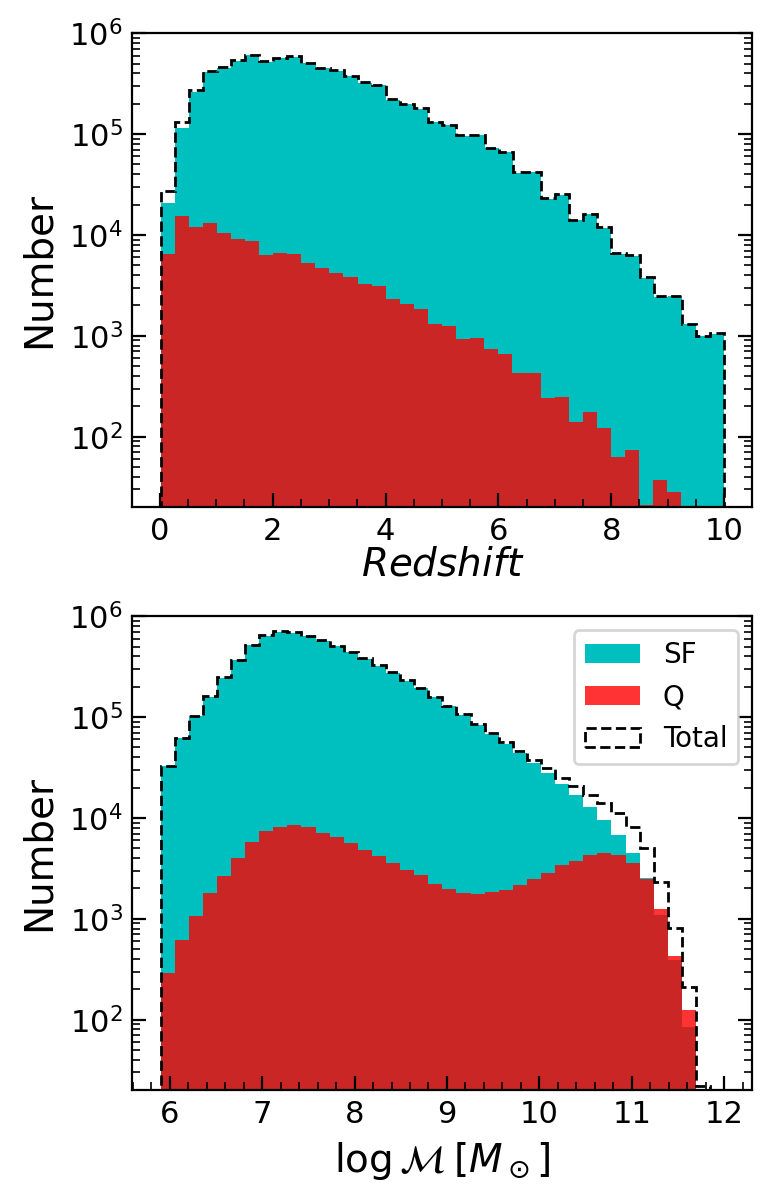

In [60]:
#SHMR (z and Ms histograms)
plt.clf()
fig = plt.figure(figsize = (4,7),dpi = 200)

plt.subplot(211)
plt.hist(df['z_app'][df['passive'] == 0], bins = 40, alpha = 1, color = 'c', label = 'SF')
plt.hist(df['z_app'][df['passive'] == 1], bins = 40, alpha = 0.8, color = 'r', label = 'Q')
plt.hist(df['z_app'], bins = 40, histtype = 'step',ls = '--', color = 'black', label = 'total')
plt.xlabel(r'$Redshift$',fontsize=14, labelpad=0)
plt.ylabel('Number',fontsize=14)
plt.tick_params(axis='both',which='major',direction='in',length=5,labelsize=11, right = True)
plt.tick_params(axis='both',which='minor',direction='in',length=3, right = True)
plt.yscale('log')
plt.ylim(20,1e6)
plt.minorticks_on()

plt.subplot(212)
plt.hist(df['m_chab'][df['passive'] == 0], bins = 40, alpha = 1, color = 'c', label = 'SF', range = [5.9,12])
plt.hist(df['m_chab'][df['passive'] == 1], bins = 40, alpha = 0.8, color = 'r', label = 'Q', range = [5.9,12])
plt.hist(df['m_chab'], bins = 40, histtype = 'step',ls = '--', color = 'black', label = 'Total', range = [5.9,12])
plt.xlabel(r'$\log \mathcal{M}\: [M_\odot]$',fontsize=14)
plt.ylabel('Number',fontsize=14)
plt.tick_params(axis='both',which='major',direction='in',length=5,labelsize=11, right = True)
plt.tick_params(axis='both',which='minor',direction='in',length=3, right = True, bottom = True)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.5))
plt.legend(fontsize = 10)
plt.yscale('log')
plt.ylim(20,1e6)
plt.minorticks_on()

plt.subplots_adjust(hspace = .23)

# plt.yticks(minor=True)

plt.show()

## AGN fraction

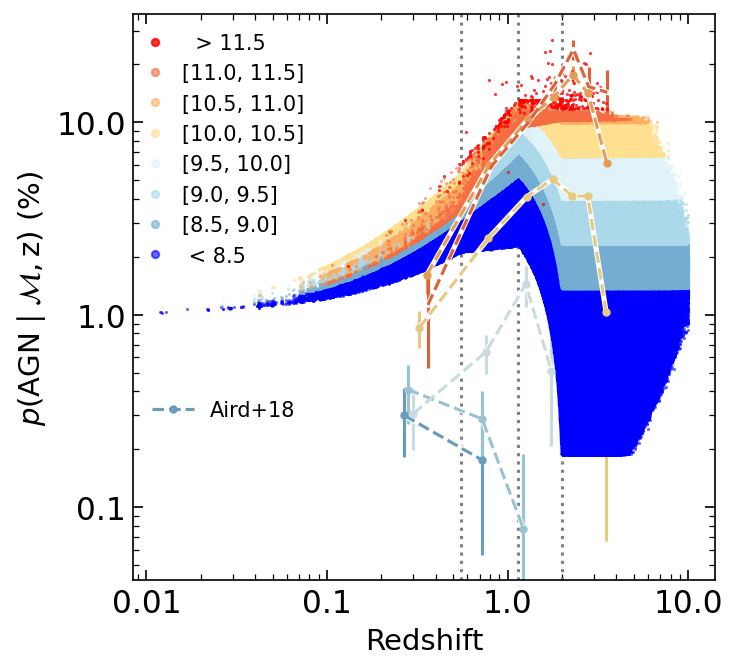

In [61]:
#@title  frac vs z with Arid
#Output duty cycle for AGN in SF
#Read points from Fig 8 in Aird+18 and use them to fit the duty cycle as a power law function of z in bins of Ms.


# my_colors = ['#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e']
my_colors = ['#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4'][::-1]
# Define a function to darken colors
def darken_color(color, intensity):
    rgb = mcolors.hex2color(color)
    darker_rgb = [c * (1 - intensity) for c in rgb]
    return mcolors.rgb2hex(darker_rgb)

# Create a new list of darker colors
my_colors2 = [darken_color(color, 0.1) for color in my_colors]
# my_colors2 = my_colors

#Read points from Fig 8 in Aird+18 and use them to fit the duty cycle as a power law function of z in bins of Ms.
ff = 'AGNfrac_SF_Aird.txt'
z1_1, frac1_1, yup1_1, ylow1_1 = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[0,1,2,3], delimiter = '|', skip_footer = 5)  # 8.5 < log(Ms/Mo) < 9
z1_2, frac1_2, yup1_2, ylow1_2 = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[4,5,6,7], delimiter = '|', skip_footer = 4)  # 9 < log(Ms/Mo) < 9.5
z2, frac2, yup2, ylow2 = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[8,9,10,11], delimiter = '|', skip_footer = 3)  # 9.5 < log(Ms/Mo) < 10
z3, frac3, yup3, ylow3 = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[12,13,14,15], delimiter = '|') # 10 < log(Ms/Mo) < 10.5
z4_1, frac4_1, yup4_1, ylow4_1 = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[16,17,18,19], delimiter = '|') # 10.5 < log(Ms/Mo) < 11
z4_2, frac4_2, yup4_2, ylow4_2 = np.genfromtxt(DATADIR+ff,unpack=True,usecols=[20,21,22,23], delimiter = '|') # 11 < log(Ms/Mo) < 11.5

# join 2 first intervals into 8.5 < log(Ms/Mo) < 9.5
z1 = np.concatenate((z1_1,z1_2))
frac1 = np.concatenate((frac1_1,frac1_2))
yup1 = np.concatenate((yup1_1,yup1_2))
ylow1 = np.concatenate((ylow1_1,ylow1_2))

# join two last intervals into 10.5 < log(Ms/Mo) < 11.5
z4 = np.concatenate((z4_1,z4_2))
frac4 = np.concatenate((frac4_1,frac4_2))
yup4 = np.concatenate((yup4_1,yup4_2))
ylow4 = np.concatenate((ylow4_1,ylow4_2))


fig, ax = plt.subplots(figsize = [5, 5], dpi = 150)
aalpha = 0.6
mss = 1


mask1= (df['m_chab'] < 8.5 )
mask2= (df['m_chab'] >= 8.5) & (df['m_chab'] < 9.0 )
mask3= (df['m_chab'] >= 9.0) & (df['m_chab'] < 9.5 )
mask4= (df['m_chab'] >= 9.5) & (df['m_chab'] < 10.0)
mask5= (df['m_chab'] >= 10.0) & (df['m_chab'] < 10.5)
mask6= (df['m_chab'] >= 10.5 ) & (df['m_chab'] < 11.0)
mask7= (df['m_chab'] >= 11.0 ) & (df['m_chab'] < 11.5)
mask8= (df['m_chab'] >= 11.5)
ax.plot(df['z_app'][mask8],df['sfAGNfrac'][mask8]*100, '.', ms = mss, color = 'red',alpha = aalpha + 0.2,zorder = 10, label = r'  > 11.5')
ax.plot(df['z_app'][mask7],df['sfAGNfrac'][mask7]*100, '.', ms = mss, color = my_colors[6],alpha = aalpha,zorder = 9, label = r'[11.0, 11.5] ')
ax.plot(df['z_app'][mask6],df['sfAGNfrac'][mask6]*100, '.', ms = mss, color = my_colors[5],alpha = aalpha,zorder = 8, label = r'[10.5, 11.0] ')
ax.plot(df['z_app'][mask5],df['sfAGNfrac'][mask5]*100, '.', ms = mss, color = my_colors[4],alpha = aalpha,zorder = 7, label = r'[10.0, 10.5] ')
ax.plot(df['z_app'][mask4],df['sfAGNfrac'][mask4]*100, '.', ms = mss, color = my_colors[3],alpha = aalpha,zorder = 6, label = r'[9.5, 10.0] ')
ax.plot(df['z_app'][mask3],df['sfAGNfrac'][mask3]*100, '.', ms = mss, color = my_colors[2],alpha = aalpha,zorder = 5, label = r'[9.0, 9.5]')
ax.plot(df['z_app'][mask2],df['sfAGNfrac'][mask2]*100, '.', ms = mss, color = my_colors[1],alpha = aalpha,zorder = 4, label = r'[8.5, 9.0]')
ax.plot(df['z_app'][mask1],df['sfAGNfrac'][mask1]*100, '.', ms = mss, color = 'blue',alpha = aalpha,zorder = 3, label = r' < 8.5')



# #Plot fractions from AIRD18
# dy1 = (yup1-ylow1)/2
# plt.plot(z1, frac1,'.--', color=my_colors2[1], label = '8.5 < M < 9.5')
# plt.errorbar(z1,frac1,yerr = dy1, linestyle='None', color=my_colors2[1])

dy1_1 = (yup1_1-ylow1_1)/2
plt.plot(z1_1, frac1_1,'-', lw =2.5, color='white', zorder = 11)
plotAird, = plt.plot(z1_1, frac1_1,'.--', color=my_colors2[1], zorder = 12)#, label = '8.5 < M < 9.0')
plt.errorbar(z1_1,frac1_1,yerr = dy1_1, linestyle='None', color=my_colors2[1])

dy1_2 = (yup1_2-ylow1_2)/2
plt.plot(z1_2, frac1_2,'-', lw =2.5, color='white', zorder = 11)
plt.plot(z1_2, frac1_2,'.--', color=my_colors2[2], zorder = 12)#, label = '9.0 < M < 9.5')
plt.errorbar(z1_2,frac1_2,yerr = dy1_2, linestyle='None', color=my_colors2[2])

dy2 = (yup2-ylow2)/2
plt.plot(z2, frac2,'-', lw =2.5, color='white', zorder = 11)
plt.plot(z2, frac2,'.--', color=my_colors2[3], zorder = 12)#, label = '9.5 < M < 10')
plt.errorbar(z2,frac2,yerr = dy2, linestyle='None', color=my_colors2[3])

dy3 = (yup3-ylow3)/2
plt.plot(z3, frac3,'-', lw =2.5, color='white', zorder = 11)
plt.plot(z3, frac3,'.--', color=my_colors2[4], zorder = 12)#, label = '10 < M < 10.5')
plt.errorbar(z3,frac3,yerr = dy3, linestyle='None', color=my_colors2[4])

# dy4 = (yup4-ylow4)/2
# plt.plot(z4, frac4,'.--', color=my_colors2[6], label = '10.5 < M < 11.5')
# plt.errorbar(z4,frac4,yerr = dy4, linestyle='None', color=my_colors2[6])

dy4_1 = (yup4_1-ylow4_1)/2
plt.plot(z4_1, frac4_1,'-', lw =2.5, color='white', zorder = 11)
plt.plot(z4_1, frac4_1,'.--', color=my_colors2[5], zorder = 12)#, label = '10.5 < M < 11.0')
plt.errorbar(z4_1,frac4_1,yerr = dy4_1, linestyle='None', color=my_colors2[5])

dy4_2 = (yup4_2-ylow4_2)/2
plt.plot(z4_2, frac4_2,'-', lw =2.5, color='white', zorder = 11)
plt.plot(z4_2, frac4_2,'--', color=my_colors2[6], zorder = 12)#, label = '11.0 < M < 11.5')
plt.errorbar(z4_2,frac4_2,yerr = dy4_2, linestyle='None', color=my_colors2[6])


ax.axvline(0.55,ls=':', c = 'grey')
# ax.text(0.3,21,'z = 0.55')
ax.axvline(1.15,ls=':', c = 'grey')
# ax.text(0.65,22,'z = 1.15')
ax.axvline(2,ls=':', c = 'grey')
# ax.text(2.03,24,'z = 2.00')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$p\left(\rm AGN \mid \mathcal{M}, z\right)$ (%)',fontsize=14)
ax.set_xlabel('Redshift',fontsize=14)
ax.tick_params(axis='both',which='major',direction='in',length=5,labelsize=15, right = True, top = True)
ax.tick_params(axis='both',which='minor',direction='in',length=3, right = True, top = True)
# ax.set_ylim([0,20])
# ax.grid(which = 'both')
# ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(float(x), ',')))
ax.get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(float(x), ','))) #Prevent scientific notation
# ax.set_xlim(0.05,5)

leg1 = ax.legend(loc = 2,markerscale =7,fontsize = 10, frameon = False, bbox_to_anchor=(-0.03, 1),handletextpad = 0.3)
ax.add_artist(leg1)
ax.legend([plotAird],['Aird+18'],loc = 3,fontsize = 10, frameon = False, bbox_to_anchor=(0., 0.25))

# leg1 = ax.legend(loc = 3,markerscale =7,fontsize = 10, frameon = False,handletextpad = 0.3, bbox_to_anchor=(-0.03, 0))
# ax.add_artist(leg1)
# ax.legend([plotAird],['Aird+18'],loc = 2,fontsize = 10, frameon = False, bbox_to_anchor=(0, 0.9))


## X-ray  Luminosity Function

<Figure size 432x288 with 0 Axes>

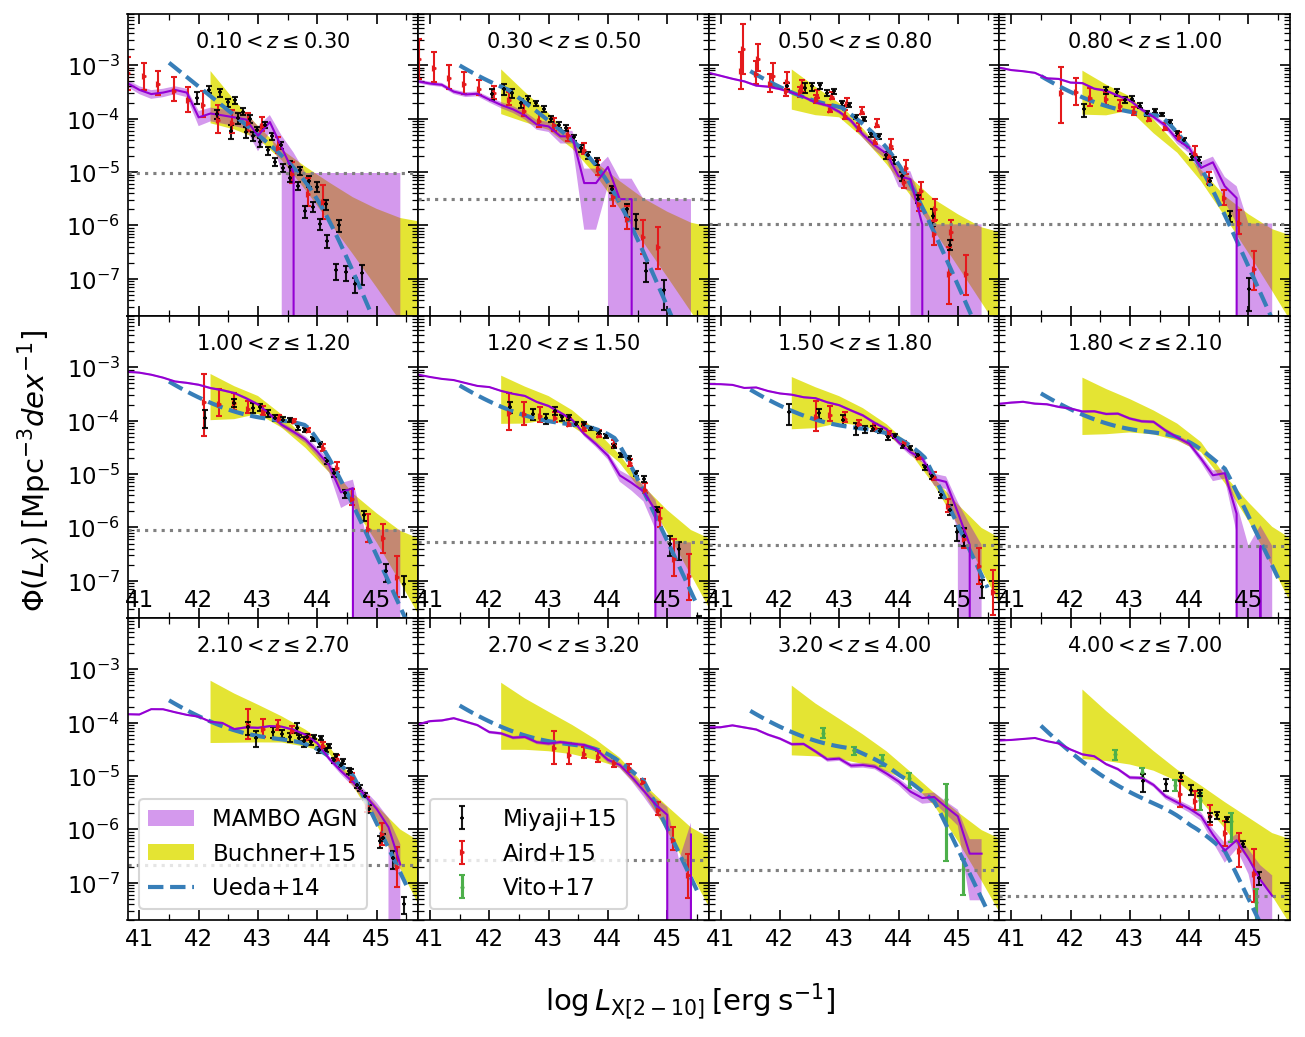

In [62]:
 #@title XLF Buchner 2015
#Plot the AGN X-ray Luminosity Function and compare it to different literature data provided by Laura Bisigello
my_colors = ['#984ea3','#dede00','#e41a1c', '#ff7f00','#f781bf', '#a65628',  '#4daf4a','#999999','#377eb8'] #colors used for the XLF
np.seterr(divide = 'ignore')

def UedaXLF(Lx, zz):
  h = 1
  A = 2.91e-6*h**3
  Ls = 43.97
  gam1 = 0.96
  gam2 = 2.71
  p1s = 4.78
  beta1 = 0.84
  zc1s = 1.86
  zc2s = 3.0
  Lp = 44
  La1 = 44.61
  La2 = 44
  alpha1 = 0.29
  alpha2 = -0.1
  p2 = -1.5
  p3 = -6.2

  zc1 = zc1s*(10**Lx/10**La1)**alpha1
  zc1[Lx > La1] = zc1s
  zc2 = zc2s*(10**Lx/10**La2)**alpha2
  zc2[Lx > La2] = zc2s

  p1 = p1s + beta1*(Lx-Lp)

  # ez = 1
  ez = (1+zc1)**p1*((1+zz)/(1+zc1))**p2
  ez[zz <= zc1] = (1+zz)**p1[zz <= zc1]
  ez[zz > zc2] = (1+zc1[zz > zc2])**p1[zz > zc2]*((1+zc2[zz > zc2])/(1+zc1[zz > zc2]))**p2*((1+zz)/(1+zc2[zz > zc2]))**p3

  phi = A/((10**Lx/10**Ls)**gam1 + (10**Lx/10**Ls)**gam2)*ez

  return phi


#------ Read observational XLF ----------
Miyaji15 = np.loadtxt(DATADIR + 'Lx_literature.txt')
obsXLF = np.loadtxt(DATADIR + 'Lx_literature2.txt')
#columns of obsXLF: 0=z, 1=ref, 2=Lx3, 3=phi, 4=low_err_phi, 5=up_err_phi
Aird10 = obsXLF[:,1] == 0
Aird15soft = obsXLF[:,1] == 1
Aird15hard = obsXLF[:,1] == 2
Vito18 = obsXLF[:,1] == 3

phi_low_err = 10**(obsXLF[:,3]) - 10**(obsXLF[:,4])
phi_up_err = 10**(obsXLF[:,5]) - 10**(obsXLF[:,3])

#Buchner15: Total AGN Intrinsic 2-10keV Luminosity function, including Compton-thick
# z0|z1|logL0|logL1|logphilo|logphihi
#  | |[10+7W]|[10+7W]|[Mpc-3]|[Mpc-3]
Buchner15 = np.loadtxt(DATADIR + 'Lx_Buchner2015_total.tsv',delimiter='|', skiprows = 45)
z_Buchner = (Buchner15[:,0] + Buchner15[:,1])/2
Lx_Buchner = (Buchner15[:,2] + Buchner15[:,3])/2
# philow_Buchner = 10**Buchner15[:,4]
# phiup_Buchner  = 10**Buchner15[:,5]
philow_Buchner = 10**Buchner15[:,4]*0.65 # Assuming that 35% of the objects are CT, and removing them
phiup_Buchner  = 10**Buchner15[:,5]*0.65 # Assuming that 35% of the objects are CT, and removing them


# # Load XLF from our catalogue with 50 realizations
# XLF_tot=np.load(DATADIR +'XLF_stats.npy')
# XLF_mean = np.mean(XLF_tot[:,1:,:],axis=2)
# XLF_median = np.median(XLF_tot[:,1:,:],axis=2)
# XLF_low = np.percentile(XLF_tot[:,1:,:],16,axis=2)
# XLF_up = np.percentile(XLF_tot[:,1:,:],84,axis=2)

ZLOW =[0.1,0.3,0.5,0.8,1.0,1.2,1.5,1.8,2.1,2.7,3.2,4.0]
ZHIGH =   [0.3,0.5,0.8,1.0,1.2,1.5,1.8,2.1,2.7,3.2,4.0,7.0]

count = 0

plt.clf()
# fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize=[20,16], dpi = 100)
fig = plt.figure(figsize=[10,8], dpi = 150)
gs = fig.add_gridspec(3, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=False, sharey=True)
for hh in [0,1,2]:
  for kk in [0,1,2,3]:
    zlow = ZLOW[count]
    zhigh = ZHIGH[count]
    #----- Plot XLFs from literature ---------
    zrange = (obsXLF[:,0]>=zlow) & (obsXLF[:,0]<zhigh)
    zrange2 = (Miyaji15[:,2]>=zlow) & (Miyaji15[:,2]<zhigh)
    zrange_Buchner = (z_Buchner>=zlow) & (z_Buchner<zhigh)
    # axs[hh,kk].errorbar(obsXLF[Aird10 & zrange][:,2],10**(obsXLF[Aird10 & zrange][:,3]), yerr = [phi_low_err[Aird10 & zrange],phi_up_err[Aird10 & zrange]], fmt = 's', capsize = 1.5,ms = 1.5,elinewidth = 1, color = 'cyan', label = 'Aird 2010')
    # axs[hh,kk].errorbar(obsXLF[Aird15soft & zrange][:,2],10**(obsXLF[Aird15soft & zrange][:,3]), yerr = [phi_low_err[Aird15soft & zrange],phi_up_err[Aird15soft & zrange]], fmt = '<', capsize = 1.5,ms = 1.5,elinewidth = 1, color = 'orange', label = 'Aird 2015 soft')
    airdplot = axs[hh,kk].errorbar(obsXLF[Aird15hard & zrange][:,2],10**(obsXLF[Aird15hard & zrange][:,3]), yerr = [phi_low_err[Aird15hard & zrange],phi_up_err[Aird15hard & zrange]], fmt = '>', capsize = 1.5,ms = 1.5,elinewidth = 1,color = my_colors[2], label = 'Aird+15')
    vitoplot = axs[hh,kk].errorbar(obsXLF[Vito18 & zrange][:,2],10**(obsXLF[Vito18 & zrange][:,3]), yerr = [-phi_low_err[Vito18 & zrange],-phi_up_err[Vito18 & zrange]], fmt = '*', capsize = 1.5,ms = 1.5,elinewidth = 1.5, color = my_colors[6], label = 'Vito+17')
    miyajiplot = axs[hh,kk].errorbar(Miyaji15[zrange2][:,5],Miyaji15[zrange2][:,7]*Miyaji15[zrange2][:,9], yerr =Miyaji15[zrange2][:,8]*Miyaji15[zrange2][:,9] , fmt = '+', capsize = 1.5,ms = 1.5,elinewidth = 1, color = 'black',alpha = 0.9, label = 'Miyaji+15')
    buchnerplot = axs[hh,kk].fill_between(Lx_Buchner[zrange_Buchner], philow_Buchner[zrange_Buchner],phiup_Buchner[zrange_Buchner],color = my_colors[1], alpha = 0.8, label = 'Buchner+15',edgecolor="none")

    #------ Calculate and plot Ueda 2014 model ---------
    LxUeda = np.linspace(41.5,45.5)
    zUeda = (zlow + zhigh)/2
    phiUeda = UedaXLF(LxUeda,zUeda)
    uedaplot, = axs[hh,kk].plot(LxUeda,phiUeda, label = 'Ueda+14', ls = '--', lw = 2, color = my_colors[8])

    # #------ Calculate and plot Gilli 2007 model ---------
    # phiGilli = GilliXLF(zUeda) #phiGilli is a dataframe
    # axs[hh,kk].plot(phiGilli['L'],10**phiGilli['logphi'], label = 'Gilli 2007', ls = ':', lw = 2, color = 'palevioletred')



    vol1 = cosmo.comoving_volume(zlow).value/(360*360/np.pi)
    vol2 = cosmo.comoving_volume(zhigh).value/(360*360/np.pi)

    #----- Construct XLF from our mock ---------
    ##### MF of AGN ######
    # zzz = np.where((df['z_app']>zlow) & (df['z_app']<=zhigh))
    zzz = np.where((df['z_app']>zlow) & (df['z_app']<=zhigh) & (df['agn'] != 0))
    Lx_tot = df['Lx'].iloc[zzz]
    # plt.title('Lambda from Bongriono 2016')
    # plt.title('Lambda from Aird 2018')
    dex = 0.2
    # if zlow > 1.2: dex = 0.3
    # L_min = round(np.min((Lx_tot))+dex/2,1)
    # L_max = round(np.max((Lx_tot))+dex/2,1)
    L_min = 40.5
    L_max = 45.5
    n_bins = int((L_max-L_min)/dex)
    n = np.zeros((n_bins))
    Lx_plot = np.zeros(n_bins)
    for jj in range(n_bins):
      iii = np.where(np.logical_and(((Lx_tot)>=L_min+(jj*dex)),((Lx_tot)<L_min+((jj+1)*dex))))
      n[jj]=len(Lx_tot.iloc[iii])
      Lx_plot[jj]=(L_min)+(jj*dex)+dex/2
    phi_agn = n/(area_mambo*(vol2-vol1)*dex)
    err_phi_agn = np.sqrt(n+1)/(area_mambo*(vol2-vol1)*dex)
#     XLF_median = np.median(XLF_tot[:,1:,:],axis=2)
#     XLF_low = np.percentile(XLF_tot[:,1:,:],16,axis=2)
#     XLF_up = np.percentile(XLF_tot[:,1:,:],84,axis=2)
    axs[hh,kk].plot(Lx_plot,phi_agn,'-',lw=1,ms=8,color='darkviolet',label='MAMBO AGN')
    mamboplot = axs[hh,kk].fill_between(Lx_plot,phi_agn + err_phi_agn,phi_agn - err_phi_agn,alpha = 0.4 ,color='darkviolet',edgecolor="none")
    # axs[hh,kk].plot(Lx_plot,XLF_median[count,:],'-',lw=1,ms=8,color='orange',label='MAMBO AGN')
    # mamboplot = axs[hh,kk].fill_between(Lx_plot,XLF_up[count,:],XLF_low[count,:],alpha = 0.4 ,color='darkviolet',edgecolor="none")



    axs[hh,kk].set_title(('%.2f'%(zlow)+ r'$ < z \leq %.2f$'%(zhigh)),fontsize=10, y = 0.85)
    axs[hh,kk].set_yscale('log')
    axs[hh,kk].set_ylim([2e-8,9e-3])
    axs[hh,kk].set_xlim([40.8,45.7])
    axs[hh,kk].tick_params(axis='both',which='major',direction='in',right=True, top = True, labelright = True, labeltop = True,length=5,labelsize=11)
    axs[hh,kk].tick_params(axis='both',which='minor',direction='in',right=True, top = True, labelright = True, labeltop = True,length=3)
    axs[hh,kk].set_xticks([41,42,43,44,45])
    # axs[hh,kk].set_yticks(np.power(10,[-7.,-6.,-5.,-4.,-3.]))
    axs[hh,kk].set_xticks([41.5,42.5,43.5,44.5,45.5],minor = True)
    axs[hh,kk].axhline(1/(area_mambo*(vol2-vol1)*dex),ls = ':', color= 'grey')

    # axs[hh,kk].axvline(42, ls = ':', c = 'red', lw = 1)
    count += 1


##### Figure params ######
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.text(0.5, 0.05, r'$\log L_{\mathrm{X [2-10]}}\:[\rm erg\:s^{-1}]$', ha='center', fontsize=14)
fig.text(0.05, 0.5, r'$\Phi(L_X) \: [\mathrm{Mpc}^{-3} dex^{-1}]$', va='center', rotation='vertical', fontsize=14)
# axs[0,0].set_ylabel(r'$\log \phi[\mathrm{Mpc}^{-3} h_{70}^{3}/mag^{-1}]$',fontsize=12)
for ax in axs.flat:
    # ax.set_xlabel('$\log L_X [erg/s]$',fontsize=13)
    ax.label_outer()

axs[2,0].legend([mamboplot,buchnerplot,uedaplot],['MAMBO AGN', 'Buchner+15','Ueda+14' ], fontsize = 11)
axs[2,1].legend([miyajiplot,airdplot,vitoplot],['Miyaji+15', 'Aird+15','Vito+17' ], fontsize = 11)
# axs[2,2].legend([mamboplot2,mamboplot3],['MAMBO AGN  \n (with Aird+18 \n fractions and Lx)', '$\\lambda > 0.01$' ], fontsize = 9, loc = 3)
# axs[2,2].legend([mamboplot2],['MAMBO AGN  \n (with Aird+18 Lx)' ], fontsize = 9, loc = 3)
# plt.legend(loc = 8,framealpha=1, fontsize =12, borderaxespad = -12.4)
# plt.savefig(HOMEDIR+'/FIGURES/Mass_Function_Spritz_z'+str(hh+1)+'.png')
plt.show()
